# Import Modules

In [1]:
using HDF5, Plots, Statistics
#using MorporJ
include("../src/MorporJ.jl")

Main.MorporJ

# Import Learning Snapshots

In [3]:
N = 1001
M = N

tol_icdf = 1e-5
tol_cdf = 1e-12

### Vectors of Parameters used for learning

#=
β = [2]
μ = [1,5,10,20,30,50,75,100]
y = [0.0]
t = collect(2:1:51)
=#

β = [2,3,4,5,6]
μ = [10,40,70,100]
y = [0.0]
t = collect(1:10:46)

### Vectors of Parameters used for testing

#=
βₜ = [2] #[2,3,4,5,6]                #[]
μₜ = [1,5,10,20,30,50,75,100]
yₜ = [0.0]                      #[0., 100., 200., 300., 400., 500.]
tₜ = collect(2:1:51)
=#

βₜ = [2,3,4,5,6]
μₜ = [10,20,30,40,50,60,70,80,90,100]
yₜ = [0.0]              # [0.0, 50.0, 100.0, 150.0, 200.0]
tₜ = collect(1:5:46)


# Tensor of snapshots and reshaping map
A = zeros(length(β), length(μ), length(y), length(t), N)
ci = CartesianIndices(size(A)[1:(end-1)])

Aₜ = zeros(length(βₜ), length(μₜ), length(yₜ), length(tₜ), N)
ciₜ = CartesianIndices(size(Aₜ)[1:(end-1)])

fid = h5open("../snapshots/data_snap_6.h5", "r")
#fid = h5open("../snapshots/data_snapshots.h5", "r")

for i in eachindex(β)
    for j in eachindex(μ)
        for k in eachindex(y)
            g = read(fid, "HL_snap_mu_$(μ[j])")
            #dset = g["snap_exp_$(β[i])"]
            dset = g["exp_$(β[i])_LPjump_$(y[k])"]
            for l in eachindex(t)
                A[i,j,k,l,1] = 0    # add zero at position -ε
                A[i,j,k,l,2:end] .= dset[t[l],:]
            end
        end
    end
end

for i in eachindex(βₜ)
    for j in eachindex(μₜ)
        for k in eachindex(yₜ)
            g = read(fid, "HL_snap_mu_$(μₜ[j])")
            #dset = g["snap_exp_$(βₜ[i])"]
            dset = g["exp_$(βₜ[i])_LPjump_$(yₜ[k])"]
            for l in eachindex(tₜ)
                Aₜ[i,j,k,l,1] = 0    # add zero at position -ε
                Aₜ[i,j,k,l,2:end] .= dset[tₜ[l],:]
            end
        end
    end
end


paramnames = ("β", "μ", "y", "t")
params = (1.0*β, 1.0*μ, 1.0*y, 1.0*t)
paramsₜ = (1.0*βₜ, 1.0*μₜ, 1.0*yₜ, 1.0*tₜ)

# Snapshot matrix: N × nₜₚ
S = reshape(A,:,N)'
Sₜ = reshape(Aₜ,:,N)'

nₜₚ = size(S)[2]
Nₜₚ = size(Sₜ)[2]
close(fid)
nₜₚ, Nₜₚ

(100, 500)

# Compute ICDFs

In [4]:
xgrid = collect(range(0, 1, length = N)); pgrid = collect(range(0, 1, length = M))
Δx = xgrid[2] - xgrid[1]; Δp = pgrid[2] - pgrid[1]

# normalize
S₁, mass = MorporJ.get_S₁(S, Δx)
S₁ₜ, massₜ = MorporJ.get_S₁(Sₜ, Δx)

# icdfs
s = MorporJ.get_s(S₁, Δx, xgrid, pgrid)
sₜ = MorporJ.get_s(S₁ₜ, Δx, xgrid, pgrid);

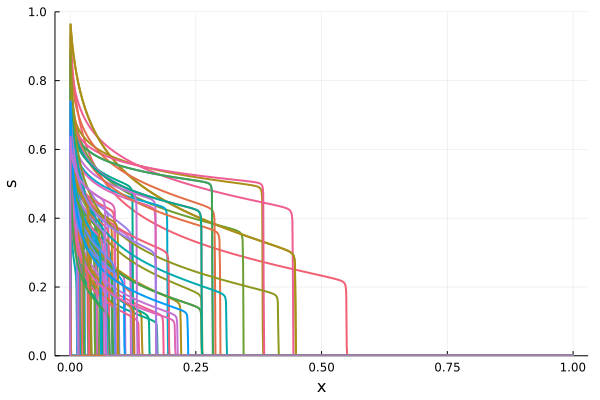

In [5]:
#plot(Sₜ[:,:], 
plot(xgrid, Sₜ[:,rand(1:Nₜₚ,100)],
    xlabel="x", ylabel="s", linewidth=2, legend=:none, ylim=(0,1))
#savefig("pictures/example1_snaps.png")

# Dictionary Learning


In [7]:
a, basis_index = MorporJ.get_initial_atoms(s);
basis_index

2-element Vector{Int64}:
 81
  1

In [8]:
Λ, ΔW, ΔW_max, ΔW_avg, a, basis_index = MorporJ.greedy_algo!(s, a, Δp, basis_index; 
                                                    rtol=-Inf, 
                                                    tol=1e-5, 
                                                    max_iter_greedy=9, 
                                                    max_iter_solver=Int(1e5));

------------------------------------- 
Iteration 1 


Maximum W2 error: 1.78e-02 
Average W2 error: 3.04e-03 
Atoms used: 81 1 
------------------------------------- 
Adding snapshot number: 83 


------------------------------------- 
Iteration 2 
Maximum W2 error: 5.13e-03 
Average W2 error: 6.00e-04 
Atoms used: 81 1 83 
------------------------------------- 
Adding snapshot number: 86 
------------------------------------- 


Iteration 3 
Maximum W2 error: 3.88e-03 
Average W2 error: 3.14e-04 
Atoms used: 81 1 83 86 
------------------------------------- 
Adding snapshot number: 82 
------------------------------------- 


Iteration 4 
Maximum W2 error: 2.86e-03 
Average W2 error: 2.68e-04 
Atoms used: 81 1 83 86 82 
------------------------------------- 
Adding snapshot number: 85 


------------------------------------- 
Iteration 5 
Maximum W2 error: 1.23e-03 
Average W2 error: 9.15e-05 
Atoms used: 81 1 83 86 82 85 
------------------------------------- 
Adding snapshot number: 96 


------------------------------------- 
Iteration 6 
Maximum W2 error: 6.69e-04 
Average W2 error: 4.64e-05 
Atoms used: 81 1 83 86 82 85 96 
------------------------------------- 
Adding snapshot number: 84 
------------------------------------- 


Iteration 7 
Maximum W2 error: 1.93e-04 
Average W2 error: 3.98e-05 
Atoms used: 81 1 83 86 82 85 96 84 
------------------------------------- 
Adding snapshot number: 87 
------------------------------------- 


Iteration 8 
Maximum W2 error: 1.65e-04 
Average W2 error: 3.33e-05 
Atoms used: 81 1 83 86 82 85 96 84 87 
------------------------------------- 
Adding snapshot number: 91 


------------------------------------- 
Iteration 9 
Maximum W2 error: 7.65e-05 
Average W2 error: 3.21e-05 
Atoms used: 81 1 83 86 82 85 96 84 87 91 
------------------------------------- 
Maximum iterations reached: 9 


In [9]:
print("Parameter values chosen by the greedy algorithm: \n")
print(paramnames)
print("\n")
for a in basis_index
    (i,j,k,l) = Tuple(ci[a])
    print(params[1][i], " ", params[2][j], " ", params[3][k], " ",  params[4][l])
    print("\n")
end

Parameter values chosen by the greedy algorithm: 
("β", "μ", "y", "t")


2.0 10.0 0.0 41.0
2.0 10.0 0.0 1.0
4.0 10.0 0.0 41.0
2.0 40.0 0.0 41.0
3.0 10.0 0.0 41.0
6.0 10.0 0.0 41.0
2.0 100.0 0.0 41.0
5.0 10.0 0.0 41.0
3.0 40.0 0.0 41.0
2.0 70.0 0.0 41.0


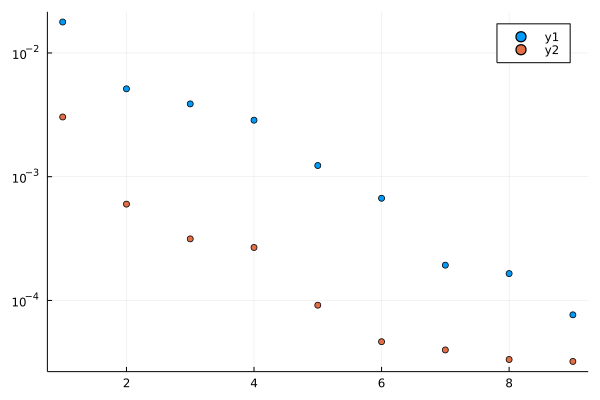

In [10]:
scatter([ΔW_max ΔW_avg], yaxis = :log)

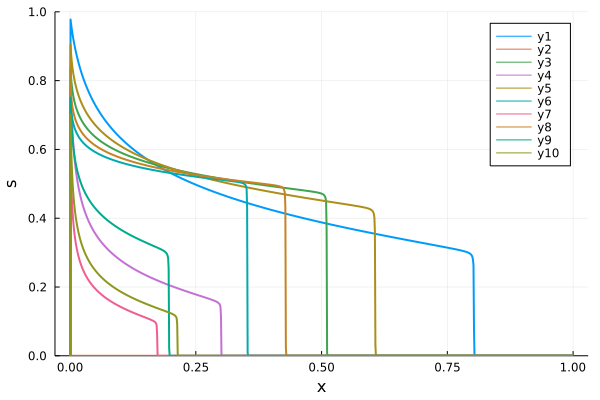

In [11]:
plot(xgrid, S[:,basis_index], xlabel="x",ylabel="s",linewidth=2, ylim=(0,1), 
    #label=[ "s₁: icdfₛ₁ = a₁" "s₂: icdfₛ₂ = a₂" "s₃: icdfₛ₃ = a₃"],
    legend = :topright)
#savefig("pictures/example1_atoms.png")

# Interpolations

In [12]:
itp, mass_itp = MorporJ.get_interpolates(params, Λ[end], mass);

In [13]:
β_axis = collect(range(βₜ[1], βₜ[end], length=50))
μ_axis = collect(range(μₜ[1], μₜ[end], length=50))
y_axis = collect(range(yₜ[1], yₜ[end], length=50))
t_axis = collect(range(tₜ[1], tₜ[end], length=50));

In [14]:
plts = Tuple(surface(μ_axis, t_axis, (x,y) -> itp[i](3.0, x, y)', zlim=[0, 1], zlab="λ[$i]", xlab="μ", ylab="t", camera=(60,60), legend = :none ) for i in 1:length(a) );
massplt = surface(μ_axis, t_axis, (x,y) -> mass_itp(3.0, x, y)', zlab="m", xlab="μ", ylab="t", camera=(60,30), legend = :none );

┌ Error: Some Julia code in the VS Code extension crashed
└ @ VSCodeServer /home/tobias/.vscode/extensions/julialang.language-julia-insider-1.5.10/scripts/error_handler.jl:15
ERROR: 

MethodError: no method matching 

size(::Interpolations.GriddedInterpolation{Float64, 3, Float64, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}}})
The applicable method may be too new: running in world age 29631, while current world is 29923.


Closest candidates are:
  size(::Interpolations.GriddedInterpolation) at /home/tobias/.julia/packages/Interpolations/Glp9h/src/gridded/gridded.jl:143 (method too new to be called from this world context.)
  size(::AbstractArray{T, N}, ::Any) where {T, N} at abstractarray.jl:38
  size(::Union{LinearAlgebra.QR, LinearAlgebra.QRCompactWY, LinearAlgebra.QRPivoted}) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/qr.jl:558
  ...
Stacktrace:
 [1] axes
   @ ./abstractarray.jl:89 [inlined]
 [2] summary(io::IOBuffer, a::Interpolations.GriddedInterpolation{Float64, 3, Float64, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}}})
   @ Base ./show.jl:2651
 [3] showerror(io::IOBuffer, ex::BoundsError)
   @ Base ./errorshow.jl:43
 [4] sprint(f::Function, args::BoundsError; context::Nothing, sizehint::Int64)
   @ Base ./strings/io.jl:105
 [5] sprint(f::Function

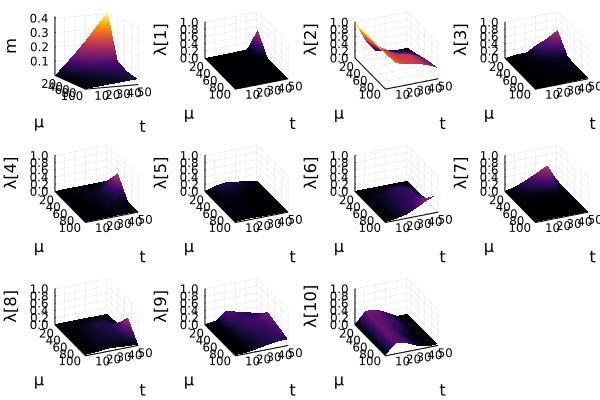

In [102]:
plot(massplt, plts...)
#savefig("pictures/example1_interpolates.png")

# Testing

In [103]:
Sᵣ, mᵣ, Sₑ = MorporJ.test_interpolations(Λ[end], mass, a, params, massₜ, paramsₜ, Sₜ, sₜ, ciₜ, Δx, xgrid, pgrid, tol_icdf);

In [104]:
using LinearAlgebra
#ΔW2 = [ norm( iSₜ[:,k] - iSᵣ[:,k], 2) * sqrt(Δp) for k in 1:Nₜₚ ]
ΔL2 = [ norm( Sₜ[:,k] - Sᵣ[:,k], 2) / norm( Sₜ[:,k], 2) for k in 1:Nₜₚ ]
ΔL1 = [ norm( Sₜ[:,k] - Sᵣ[:,k], 1) / norm( Sₜ[:,k], 1) for k in 1:Nₜₚ ]
ΔL1ₑ = [ norm( Sₜ[:,k] - Sₑ[:,k], 1) / norm( Sₜ[:,k], 1) for k in 1:Nₜₚ ];


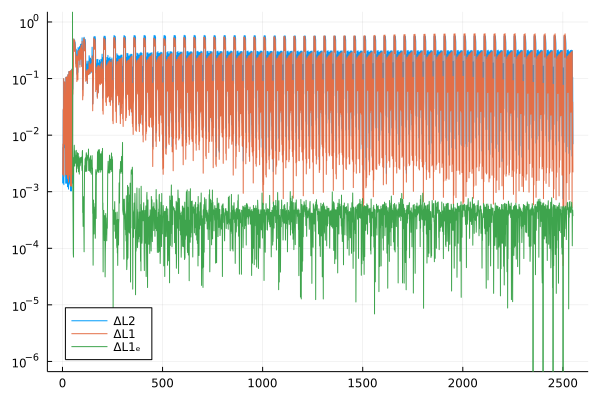

In [105]:
plot( [ΔL2, ΔL1, ΔL1ₑ], yaxis=:log, legend=:bottomleft, label=["ΔL2" "ΔL1" "ΔL1ₑ"], ylim=[1e-6,1e-0])

In [106]:
sum(ΔL2)/Nₜₚ, sum(ΔL1)/Nₜₚ, sum(ΔL1ₑ)/Nₜₚ

(0.20362602717599287, 0.14680886663228646, 0.039749064933091494)

# Generate Traces

In [107]:
U = svd(S).U;

In [108]:
nᵢₜ = length(Λ)

avgΔL1_tr = zeros(nᵢₜ)
maxΔL1_tr = zeros(nᵢₜ)

for k in 1:nᵢₜ
    Sᵣ, mᵣ, Sₑ = MorporJ.test_interpolations(Λ[k], mass, a[1:(k+1)], params, massₜ, paramsₜ, Sₜ, sₜ, ciₜ, Δx, xgrid, pgrid, tol_icdf);

    ΔL1 = [ norm( Sₜ[:,k] - Sᵣ[:,k], 1) / norm( Sₜ[:,k], 1) for k in 1:Nₜₚ ]

    avgΔL1_tr[k] = sum( ΔL1 )/length(ΔL1)
    maxΔL1_tr[k] = maximum( ΔL1 )

end

In [109]:
nₚₒ = nᵢₜ+1

avgΔL1_tr_pod = zeros(nₚₒ-1)
maxΔL1_tr_pod = zeros(nₚₒ-1)

for k in 2:nₚₒ
    Ψ = U[:,1:k]
    Π = Ψ * Ψ'
    ΔL1_pod = [ norm( Sₜ[:,i] - Π * Sₜ[:,i], 1) / norm( Sₜ[:,i], 1) for i in 1:Nₜₚ ]

    avgΔL1_tr_pod[k-1] = sum( ΔL1_pod )/length(ΔL1_pod)
    maxΔL1_tr_pod[k-1] = maximum( ΔL1_pod )

end
    

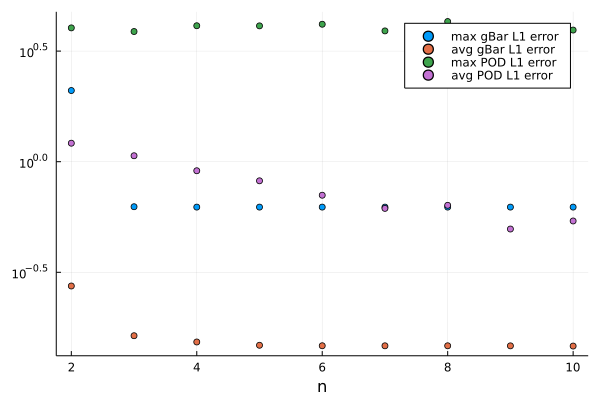

In [110]:
scatter(2:nₚₒ,
    [
    maxΔL1_tr, 
    avgΔL1_tr,
    maxΔL1_tr_pod,
    avgΔL1_tr_pod,
    ],
    label=["max gBar L1 error" "avg gBar L1 error" "max POD L1 error" "avg POD L1 error"],
    xlab = "n",
    yaxis=:log)
    #savefig("pictures/example1_traces.png")
    

# Comparison with POD

In [111]:
nₚₒ = 50
nₐ = 3
Ψ = U[:,1:nₚₒ]
Π = Ψ * Ψ'

Sᵣ, mᵣ, Sₑ = MorporJ.test_interpolations(Λ[nₐ-1], mass, a[1:nₐ], params, massₜ, paramsₜ, Sₜ, sₜ, ciₜ, Δx, xgrid, pgrid, tol_icdf);
ΔL1 = [ norm( Sₜ[:,k] - Sᵣ[:,k], 1) / norm( Sₜ[:,k], 1) for k in 1:Nₜₚ ];

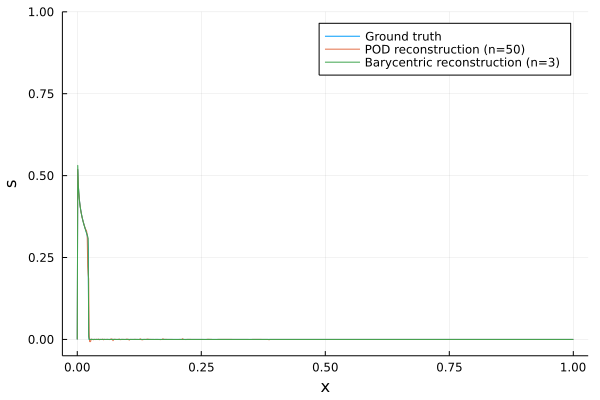

In [118]:
iₑₓ = rand(1:Nₜₚ)

plot(xgrid, Sₜ[:,iₑₓ], label="Ground truth", xlabel="x", ylabel="s", ylim=(-0.05,1))
plot!(xgrid, Π * Sₜ[:,iₑₓ], label="POD reconstruction (n=$nₚₒ)")
plot!(xgrid, Sᵣ[:,iₑₓ], label="Barycentric reconstruction (n=$nₐ)")
#savefig("pictures/example1_recon.png")

In [113]:
ΔL1[iₑₓ], norm(Sₜ[:,iₑₓ] - Π * Sₜ[:,iₑₓ],1)/norm(Sₜ[:,iₑₓ],1)

(0.071173461576263, 0.029034365374238782)

In [114]:
iₑₓ

2178

In [115]:
ΔL1_pod = [ norm( Sₜ[:,i] - Π * Sₜ[:,i], 1) / norm( Sₜ[:,i], 1) for i in 1:Nₜₚ ]
sum(ΔL1_pod)/Nₜₚ

0.08759621976684065